# VQC vs MLP

In [205]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [206]:
import numpy as np
import torch

def plot_decision_boundary(model, X, y, title, is_torch=False):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]

    if is_torch:
        with torch.no_grad():
            Z = model(torch.tensor(grid, dtype=torch.float32)).numpy()
    else:
        Z = model.predict_proba(grid)[:, 1]

    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6,4))
    plt.contourf(xx, yy, Z, levels=30, cmap="coolwarm", alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", s=25, edgecolor="k")
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.tight_layout()
    plt.show()

### Creating Data

**Circles**

In [255]:
X_circles, y_circles = make_circles(
    n_samples=7000,
    noise=0.2,
    factor=0.6,
    random_state=42
)

X_circles = StandardScaler().fit_transform(X_circles)

X_circles_train, X_circles_test, y_circles_train, y_circles_test = train_test_split(
    X_circles, y_circles, test_size=0.3, random_state=42
)

**Moons**

In [256]:
X_moons, y_moons = make_moons(
    n_samples=7000,
    noise=0.2,
    random_state=42
)

X_moons = StandardScaler().fit_transform(X_moons)

X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(
    X_moons, y_moons, test_size=0.3, random_state=42
)

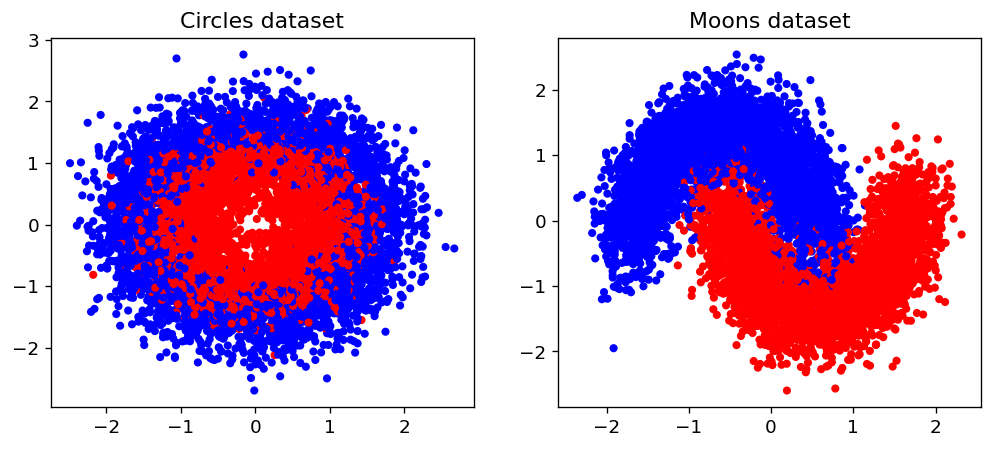

In [257]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap='bwr', s=15)
axes[0].set_title("Circles dataset")

axes[1].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='bwr', s=15)
axes[1].set_title("Moons dataset")

plt.show()


### MLP baseline (классическая нейросеть)

In [258]:
mlp = MLPClassifier(
    hidden_layer_sizes=(16,),
    activation="relu",
    solver="adam",
    max_iter=2000,
    random_state=42
)

mlp.fit(X_circles_train, y_circles_train)
mlp_acc = accuracy_score(y_circles_test, mlp.predict(X_circles_test))

mlp_acc

0.8438095238095238

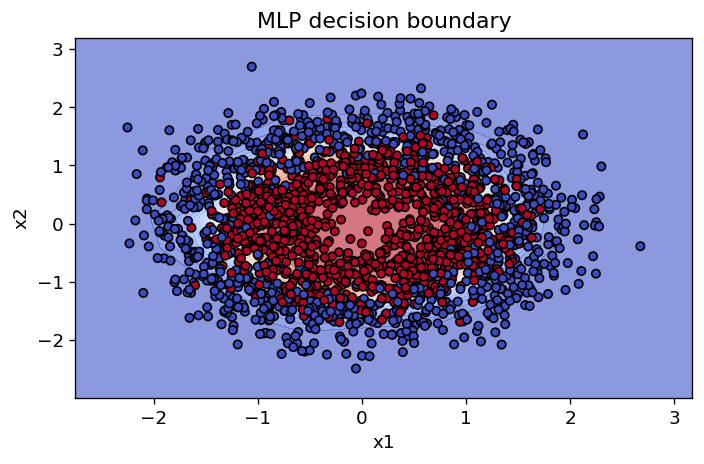

In [259]:
plot_decision_boundary(
    mlp,
    X_circles_test,
    y_circles_test,
    title="MLP decision boundary"
)

### Суть вариационной квантовой схемы (VQC)

**Variational Quantum Classifier (VQC)** — это квантово-классическая модель машинного обучения, в которой классификация осуществляется с помощью параметризованной квантовой схемы, оптимизируемой градиентными методами.

В общем виде модель можно представить как отображение

$$
x \xrightarrow{\text{embedding}} |\psi(x)\rangle
:\xrightarrow{\text{parametrized circuit}}
:\xrightarrow{\text{measurement}}
\hat{y}
$$

где:

* $x \in \mathbb{R}^d$ — входной вектор признаков,
* $|\psi(x)\rangle$ — квантовое состояние, кодирующее входные данные,
* $\hat{y}$ — предсказание модели.



#### Что происходит математически

**1. Кодирование данных (AngleEmbedding)**
```
Классические данные (x₁, x₂) → Квантовое состояние
```
Каждое число становится углом вращения кубита:
$$|ψ\rangle = R_Y(x_1)|0\rangle_1 \otimes R_Y(x_2)|0\rangle_2$$

**2. Вариационные слои (StronglyEntanglingLayers)**

Для каждого слоя:
- **Вращения**: 3 угла (θ₁, θ₂, θ₃) поворачивают каждый кубит произвольным образом
- **CNOT**: запутывает кубиты → они начинают "влиять друг на друга"

Итого: 2 слоя × 2 кубита × 3 угла = **12 обучаемых параметров**

**3. Измерение**
```
Квантовое состояние → Число в [-1, 1]
```
$$\langle Z_0 \rangle = P(\text{кубит в }|0\rangle) - P(\text{кубит в }|1\rangle)$$

**4. Sigmoid**
```
[-1, 1] → [0, 1] (вероятность класса)
```

#### Физический смысл

- **Вращения** = настраиваемые фильтры для признаков
- **Запутывание** = нелинейное взаимодействие между признаками (как скрытые слои в нейросети)
- **Измерение** = проекция результата в классическое число

#### Почему это "квантовое"?

Квантовое запутывание позволяет 2 кубитам исследовать **4-мерное** пространство состояний одновременно, а не по очереди. Для n кубитов — это $2^n$ измерений, что дает потенциальное преимущество.

#### Обучение

Градиенты вычисляются квантовым способом:
$$\frac{\partial f}{\partial θ} = \frac{f(θ + π/2) - f(θ - π/2)}{2}$$

Запускаем схему с чуть разными углами, сравниваем результаты — получаем направление для оптимизации.

---

**Вся схема**: данные → квантовое кодирование → параметризованные унитарные преобразования с запутыванием → измерение → классическая функция активации → предсказание

In [260]:
import pennylane as qml
import torch
import torch.nn as nn

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits) # Используем квантовый симулятор

# Квантовая схема
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits)) # Embedding (кодирование признаков): каждый признак -> угол вращения
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits)) # Ansatz (вариационная схема): аналог скрытых слоев нейросети
    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (2, n_qubits, 3)}
quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes) # Оборачивание в PyTorch слой

model = nn.Sequential(
    quantum_layer,
    nn.Sigmoid() # Вероятность класса
)

In [261]:
X_train_t = torch.tensor(X_circles_train, dtype=torch.float32)
y_train_t = torch.tensor(y_circles_train, dtype=torch.float32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.BCELoss()

for epoch in range(100):
    optimizer.zero_grad()
    preds = model(X_train_t).squeeze()
    loss = loss_fn(preds, y_train_t)
    loss.backward()
    optimizer.step()

with torch.no_grad():
    preds = model(torch.tensor(X_circles_test, dtype=torch.float32)).squeeze()
    y_pred = (preds > 0.5).int().numpy()

accuracy = (y_pred == y_circles_test).mean()
accuracy

np.float64(0.6866666666666666)

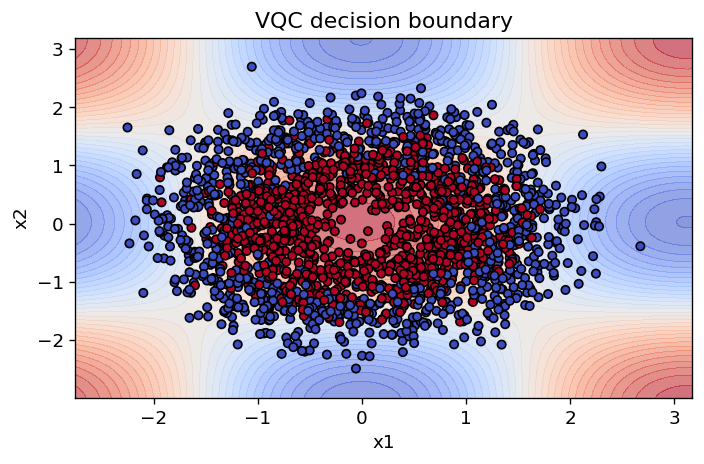

In [262]:
plot_decision_boundary(
    model,
    X_circles_test,
    y_circles_test,
    title="VQC decision boundary",
    is_torch=True
)


### VQC - как нелинейный преобразователь признаков

In [263]:
import pennylane as qml
import torch
import torch.nn as nn


n_qubits = 2
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

# Feature map: простой нелинейный embedding
def feature_map(x):
    return torch.tensor([x[0], x[1], x[0]*x[1], x[0]**2], dtype=torch.float32)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits)) # Embedding (кодирование признаков): каждый признак -> угол вращения
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits)) # Ansatz (вариационная схема)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weight_shapes = {"weights": (n_layers, n_qubits, 3)}
quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

# Гибрид: квантовый слой + классический линейный слой
model = nn.Sequential(
    quantum_layer,
    nn.Linear(n_qubits, 1),
    nn.Sigmoid()
)


In [264]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.BCELoss()

X_train_t = torch.tensor(X_circles_train, dtype=torch.float32)
y_train_t = torch.tensor(y_circles_train, dtype=torch.float32)

model.train()
for epoch in range(150):
    optimizer.zero_grad()
    preds = model(X_train_t).squeeze()
    loss = loss_fn(preds, y_train_t)
    loss.backward()
    optimizer.step()

model.eval()
with torch.no_grad():
    preds = model(torch.tensor(X_circles_test, dtype=torch.float32)).squeeze()
    y_pred = (preds > 0.5).int().numpy()

accuracy = (y_pred == y_circles_test).mean()
accuracy

np.float64(0.8471428571428572)

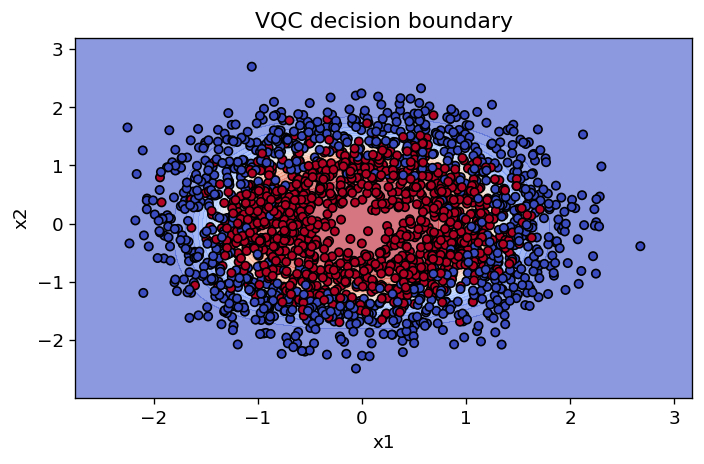

In [265]:
plot_decision_boundary(
    model,
    X_circles_test,
    y_circles_test,
    title="VQC decision boundary",
    is_torch=True
)